In [1284]:
#!/usr/bin/python3 (3.8.10 x64)
import numpy as np
import pygad
import os
import mazes

Create a function that reads the 2D representation of a maze and returns the shortest path found by a genetic algorithm.

In [1285]:
# Convert mazes into 2D array of chars
def get_maze(maze):
    res = []
    for i in range(len(maze)):
        row = list(list(maze[i])[0])
        res.append(row)
        
    return np.array(res)

In [1286]:
# Convert mazes
maze1 = get_maze(mazes.maze1)
maze2 = get_maze(mazes.maze2)
maze3 = get_maze(mazes.maze3)
maze4 = get_maze(mazes.maze4)
maze5 = get_maze(mazes.maze5)
maze6 = get_maze(mazes.maze6)
maze7 = get_maze(mazes.maze7)
maze3_T = get_maze(mazes.maze3_T) 
maze4_T = get_maze(mazes.maze4_T) 
maze5_T = get_maze(mazes.maze5_T) 
maze7_T = get_maze(mazes.maze7_T) 

In [1287]:
# Return a tuple containing indices of start
def find_start(maze):
    '''
        Return an array containing indices of start
    '''
    maze = np.array(maze)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i,j] == "S":
                return i,j

In [1288]:
# Return a tuple containing indices of end
def find_end(maze):
    '''
    Return an array containing indices of end
    '''
    maze = np.array(maze)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i,j] == "E":
                return i,j

Solution will be encoded as follows:
* It will be a vector of values (np array)
* Each value will span from 0 to 3
* Each value corresponds to a direction 
* * 0 - up
* * 1 - down
* * 2 - left
* * 3 - right

Maze: `h x w` matrix, possible values of maze[i,j]:
* `#` - wall
* `.` - valid field
* `S` - starting field
* `E` - ending field

Maze[i,j] gives:
*   (0) up = Maze[i-1, j]
*   (1) down = Maze[i+1, j]
*   (2) left = Maze[i, j-1]
*   (3) right = Maze[i, j+1]

In [1289]:
solutions = [False]
def set_solutions_false():
    solutions[0] = False
    
def shortest_path(maze, i, j, visited):
    if [i,j] in visited:
        return 0
    
    path_len = 0
    visited.append([i,j])
        
    if maze[i,j] == "E":
        solutions[0] = True;
        return 0
    
    if i > 0 and maze[i-1, j] != "#":
        path_len = shortest_path(maze, i-1, j, visited) + 1
        if solutions[0]:
            maze[i,j] = "0"
            return path_len
    
    if j > 0 and maze[i, j-1] != "#":
        path_len = shortest_path(maze, i, j-1, visited) + 1
        if solutions[0]:
            maze[i,j] = "0"
            return path_len
        
    if i < maze.shape[0]-1 and maze[i+1, j] != "#":
        path_len = shortest_path(maze, i+1, j, visited) + 1
        if solutions[0]:
            maze[i,j] = "0"
            return path_len
         
    
    if j < maze.shape[1]-1 and maze[i, j+1] != "#":
        path_len = shortest_path(maze, i, j+1, visited) + 1
        if solutions[0]:
            maze[i,j] = "0"
            return path_len    
        
    visited.remove([i,j])

    solutions[0] = False
    return path_len

solutions = [False]

In [1290]:
def get_shortest_path(maze):
    set_solutions_false()
    start = find_start(maze)
    m = maze.copy()
    res = shortest_path(m, start[0], start[1], [])
    return res, m
    

In [1305]:
# Choose which maze to solve
maze = maze2


In [1306]:
maze

array([['#', '#', '#', '#', '#', 'E', '#'],
       ['#', '.', '#', '.', '#', '.', '#'],
       ['#', '.', '.', '.', '.', '.', '#'],
       ['#', '#', '.', '#', '#', '#', '#'],
       ['#', '.', '.', '.', '.', 'S', '#'],
       ['#', '.', '#', '.', '.', '#', '#'],
       ['#', '#', '#', '#', '#', '#', '#']], dtype='<U1')

In [1307]:
import time as time

In [1308]:
path_len, _ = get_shortest_path(maze)
y, x = find_start(maze)

end = find_end(maze)

def fitness(solution, solution_index):
    '''
        Takes in a maze and a solution and solution_index
        Returns a scalar score
    '''
    score = 0
    seen = []

    i, j = y, x

    
    for move in solution:

        # Determine new position
        if move == 0:
            i -= 1
        elif move == 1:
            i += 1
        elif move == 2:
            j -= 1
        elif move == 3:
            j += 1     

 
        # Out of bounds
        if i < 0 or j < 0 or i > len(maze[0])-1 or j > len(maze[1])-1:
            return -score



        if maze[i, j] == ".":
            score += 2;        
        #if i < 0:
        #    i = 0
        #elif i > len(maze)-1:
        #    i = len(maze)-1

        #if j < 0:
        #    j = 0
        #elif j > len(maze[0])-1:
        #    j = len(maze[0])-1
        #elif position in seen:
        #    score -= len(seen);
            #break;

        # Finish
        if maze[i, j] == "E":
            
            print("SOLUTION")
            score +=  990
            return score
        
            #seen.append(position)
            #break
        #try: 
        #    m[i,j] = "X"
        #    print("move:", move, "score:", score, "\n\n", m)
        #    time.sleep(3)
        #except IndexError:
        #    print("out of bounds")
            
        # Reward staying on path 

        #    pass
            #score += 15 * (path_len - ix)
        
        # Penalize wall and path length
        if maze[i, j] == "#":
            #print(f"wall:  {score_}")
            score -= 10  # (path_len - ix)**2
            #print(f"new score_ {score_}")
            seen.append((i,j))
            #return score
            #seen.append(position)
    
    return score


In [1309]:
num_generations = 1000
num_parents_mating = 100

solutions_per_pop = 100

num_genes =  maze.shape[0]* 10
num_genes, dfs_solution = get_shortest_path(maze)
print(num_genes)

init_range_low = 0
init_range_high = 4

parent_selection_type = "sss"
keep_parents = 50

crossover_type = "single_point"
crossover_probability = 0.1

mutation_type = "swap"
mutation_probability = 0.1
mutation_percent_genes = 0.1

10


In [1310]:
def callback_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

In [1311]:
unique_vals = []
def on_crossover(ga_instance, children):
    print(ga_instance.generations_completed, children)
    unique_vals.append(children[0][0])
    
first_child = []
def on_mutation(ga_instance, children):
    first_child.append(children[0])

In [1312]:
ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness,
                        sol_per_pop=solutions_per_pop,
                        num_genes=num_genes,
                        gene_type=int,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_type,
                        #crossover_probability=crossover_probability,
                        mutation_type=mutation_type,
                        #keep_elitism=solutions_per_pop//2,
                        #random_mutation_min_val=0,
                        #random_mutation_max_val=3,
                        #mutation_by_replacement=True,
                        #suppress_warnings=True,
                        gene_space=[0,1,2,3],
                        #mutation_percent_genes=mutation_percent_genes,
                        #mutation_probability=mutation_probability,
                        on_generation=callback_gen,
                        random_seed=420,
                        #on_crossover=on_crossover
                        )

In [1313]:
def visualize(maze, solution):
    m = maze.copy()
    i, j = find_start(maze)
    sol = []
    solved = False
    for step in solution:
        try:
     
            if step == 0:
                sol.append("U")
                i -= 1
            elif step == 1:
                sol.append("D")
                i += 1
            elif step == 2:
                sol.append("L")
                j -= 1
            elif step == 3:
                sol.append("R")
                j += 1
                
                
            if m[i,j] == "E":
                solved = True
                m[i,j] = "X"
            if (i > -1 and j > -1 and solved == False):
                m[i, j] = "O" 
        except Exception as e: #IndexError:
            #pass
            print(f"Exception: {e}")
            
    return m, sol


In [1314]:
ga_instance.run()

SOLUTION
SOLUTION
SOLUTION
SOLUTION
SOLUTION
SOLUTION
SOLUTION
Generation :  1
SOLUTION
SOLUTION
Fitness of the best solution : 984
SOLUTION
SOLUTION
SOLUTION
Generation :  2
SOLUTION
SOLUTION
SOLUTION
Fitness of the best solution : 984
SOLUTION
SOLUTION
SOLUTION
Generation :  3
SOLUTION
SOLUTION
SOLUTION
Fitness of the best solution : 984
SOLUTION
SOLUTION
Generation :  4
SOLUTION
SOLUTION
Fitness of the best solution : 984
SOLUTION
SOLUTION
Generation :  5
SOLUTION
SOLUTION
Fitness of the best solution : 984
SOLUTION
Generation :  6
SOLUTION
Fitness of the best solution : 984
SOLUTION
SOLUTION
SOLUTION
Generation :  7
SOLUTION
SOLUTION
SOLUTION
Fitness of the best solution : 984
SOLUTION
SOLUTION
SOLUTION
SOLUTION
SOLUTION
SOLUTION
Generation :  8
SOLUTION
SOLUTION
SOLUTION
SOLUTION
SOLUTION
SOLUTION
Fitness of the best solution : 984
SOLUTION
SOLUTION
SOLUTION
Generation :  9
SOLUTION
SOLUTION
SOLUTION
Fitness of the best solution : 984
SOLUTION
SOLUTION
Generation :  10
SOLUTION
SO

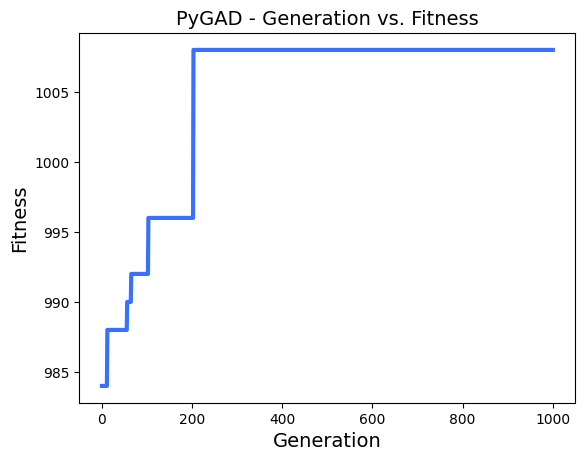

SOLUTION
Parameters of the best solution : [2 2 2 0 0 3 3 3 0 0] index =  0
Fitness value of the best solution = 1008


In [1315]:
ga_instance.plot_fitness()
ga_instance.save("maze2-solved-2")

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution), "index = ", solution_idx)
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
#print(unique_vals)
#prediction = np.sum(np.array(ins)*solution)
#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

In [1316]:
m, sol = visualize(maze, solution)

print("fitness: ", fitness([0, 1, 0, 3, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 3, 0, 1, 3, 3, 2, 2, 1, 2, 0, 3, 0, 0, 0, 0, 2, 0, 2, 1, 2, 0, 2, 3
, 3, 1, 0, 1, 0, 2, 2, 3, 0, 0, 2, 1, 3], 0))
_, dfs_solution = get_shortest_path(maze)
print("solution", sol)
print("GA\n", m, len(solution), "\n")
print("DFS\n", dfs_solution)

fitness:  56
solution ['L', 'L', 'L', 'U', 'U', 'R', 'R', 'R', 'U', 'U']
GA
 [['#' '#' '#' '#' '#' 'X' '#']
 ['#' '.' '#' '.' '#' 'O' '#']
 ['#' '.' 'O' 'O' 'O' 'O' '#']
 ['#' '#' 'O' '#' '#' '#' '#']
 ['#' '.' 'O' 'O' 'O' 'S' '#']
 ['#' '.' '#' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#']] 10 

DFS
 [['#' '#' '#' '#' '#' 'E' '#']
 ['#' '.' '#' '.' '#' '0' '#']
 ['#' '.' '0' '0' '0' '0' '#']
 ['#' '#' '0' '#' '#' '#' '#']
 ['#' '.' '0' '0' '0' '0' '#']
 ['#' '.' '#' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#']]


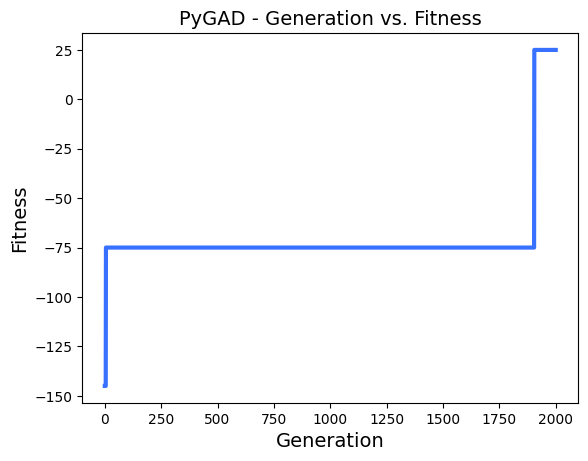

SOLUTION
(array([2, 2, 2, 0, 0, 3, 3, 3, 0, 0]), 1008, 0)


In [1317]:
loaded = pygad.load("maze2-solved")
loaded.plot_fitness()
print(loaded.best_solution())

In [1318]:
print(fitness([1, 1, 0, 2, 3, 2, 2, 0, 2, 0, 3, 3, 3, 3, 3, 0,2 ,3, 1, 2, 2, 0, 2, 1, 2], 0))
m, sol = visualize(maze, [1, 1, 0, 2, 3, 2, 2, 0, 2, 0, 3, 3, 3, 3, 3, 0,2 ,3, 1, 2, 2, 0, 2, 1, 2])
print(maze, "\n\n", m, sol)

68
Exception: index 7 is out of bounds for axis 1 with size 7
Exception: index 7 is out of bounds for axis 1 with size 7
Exception: index 7 is out of bounds for axis 1 with size 7
Exception: index 7 is out of bounds for axis 1 with size 7
[['#' '#' '#' '#' '#' 'E' '#']
 ['#' '.' '#' '.' '#' '.' '#']
 ['#' '.' '.' '.' '.' '.' '#']
 ['#' '#' '.' '#' '#' '#' '#']
 ['#' '.' '.' '.' '.' 'S' '#']
 ['#' '.' '#' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#']] 

 [['#' '#' '#' '#' '#' 'E' '#']
 ['#' '.' '#' '.' '#' '.' '#']
 ['#' '.' '.' '.' 'O' 'O' 'O']
 ['#' '#' 'O' 'O' 'O' 'O' 'O']
 ['#' '.' 'O' 'O' '.' 'S' '#']
 ['#' '.' '#' 'O' 'O' 'O' '#']
 ['#' '#' '#' '#' '#' 'O' '#']] ['D', 'D', 'U', 'L', 'R', 'L', 'L', 'U', 'L', 'U', 'R', 'R', 'R', 'R', 'R', 'U', 'L', 'R', 'D', 'L', 'L', 'U', 'L', 'D', 'L']
